<a href="https://colab.research.google.com/github/RoseJaisil/Segmentation-Algorithms/blob/main/VGG16%2BRandom_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The goal here is to apply VGG and Random Forest for the segmentation

Import libraries

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import glob
import pickle
import tifffile

from keras.models import Sequential, Model
from keras.layers import Conv2D
import os
from keras.applications.vgg16 import VGG16
from sklearn.ensemble import RandomForestClassifier

Download/ Upload the dataset

In [1]:
# from google.colab import files
# file = files.upload()

Saving sandstone_data_for_ML.zip to sandstone_data_for_ML.zip


Make Directory

In [5]:
# !mkdir data
# !mkdir data/train_images
# !mkdir data/mask_images

Unzip the files and save it in the folder

In [3]:
# !unzip sandstone_data_for_ML.zip -d data

Archive:  sandstone_data_for_ML.zip
   creating: data/sandstone_data_for_ML/
   creating: data/sandstone_data_for_ML/data_for_3D_Unet/
  inflating: data/sandstone_data_for_ML/data_for_3D_Unet/448_images_512x512.tif  
  inflating: data/sandstone_data_for_ML/data_for_3D_Unet/train_images_256_256_256.tif  
  inflating: data/sandstone_data_for_ML/data_for_3D_Unet/train_masks_256_256_256.tif  
   creating: data/sandstone_data_for_ML/full_labels_for_deep_learning/
   creating: data/sandstone_data_for_ML/full_labels_for_deep_learning/128_patches/
  inflating: data/sandstone_data_for_ML/full_labels_for_deep_learning/128_patches/images_as_128x128_patches.tif  
  inflating: data/sandstone_data_for_ML/full_labels_for_deep_learning/128_patches/masks_as_128x128_patches.tif  
  inflating: data/sandstone_data_for_ML/full_labels_for_deep_learning/train_imgs_cropped_768.tif  
  inflating: data/sandstone_data_for_ML/full_labels_for_deep_learning/train_masks_grey_cropped_768.tif  
   creating: data/sands

The input image is in the tiff format. Hence we have to unapck it.

Run the cell below to read the tiff images


In [9]:
# tiff_stack_path = '/content/data/sandstone_data_for_ML/partial_labels_for_traditional_ML/sandstone_train_images.tif'
# image = tifffile.imread(tiff_stack_path )
# mask_tiff_stack_path = '/content/data/sandstone_data_for_ML/partial_labels_for_traditional_ML/sandstone_partial_labels_from_APEER_ML.tif'
# masks = tifffile.imread(mask_tiff_stack_path)

Unpack the stacked images as individual png files

Unpacking training images

In [26]:
# with tifffile.TiffFile(tiff_stack_path) as tif:
#   i = 0
#   for im in tif.pages:
#     image = im.asarray()
#     i = i + 1
#     image_name = '/content/data/train_images/image_' + str(i)+'.png'
#     cv2.imwrite(image_name, image)

In [28]:
# with tifffile.TiffFile(mask_tiff_stack_path) as tif:
#   i = 0
#   for mask in tif.pages:
#     mask = mask.asarray()
#     i = i + 1
#     mask_name = '/content/data/mask_images/mask_' + str(i)+'.png'
#     cv2.imwrite(mask_name, mask)

Prepare the data

In [31]:
Size_X = 1024
Size_Y = 996

train_images = []

for dir_path in glob.glob("/content/data/train_images"):
  for im_path in glob.glob(os.path.join(dir_path, "*.png")):
    im = cv2.imread(im_path, cv2.IMREAD_COLOR)
    im = cv2.resize(im, (Size_Y, Size_X))
    im = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
    train_images.append(im)

  train_images = np.array(train_images)

train_masks = []

for dir_path in glob.glob("/content/data/mask_images"):
  for mask_path in glob.glob(os.path.join(dir_path, "*.png")):
    mask = cv2.imread(mask_path, 0)
    mask = cv2.resize(mask, (Size_Y, Size_X))
    train_masks.append(mask)

  train_masks = np.array(train_masks)

X_train = train_images
Y_train = train_masks
Y_train = np.expand_dims(Y_train, axis = 3)



Importing VGGnet as feature extractor

In [34]:
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(Size_X, Size_Y, 3))

for layers in VGG_model.layers:
  layers.trainable = False

VGG_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1024, 996, 3)]    0         
                                                                 
 block1_conv1 (Conv2D)       (None, 1024, 996, 64)     1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 1024, 996, 64)     36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 512, 498, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 512, 498, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 512, 498, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 256, 249, 128)     0     

Constructing the model

In [35]:
new_model = Model(inputs=VGG_model.input, outputs=VGG_model.get_layer('block1_conv2').output)
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1024, 996, 3)]    0         
                                                                 
 block1_conv1 (Conv2D)       (None, 1024, 996, 64)     1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 1024, 996, 64)     36928     
                                                                 
Total params: 38,720
Trainable params: 0
Non-trainable params: 38,720
_________________________________________________________________


Extraacting features

In [36]:
print("Extracting features...")
features = new_model.predict(X_train)

Extracting features...
1/1 [==============================] - 23s 23s/step


Plot the feautres predicted

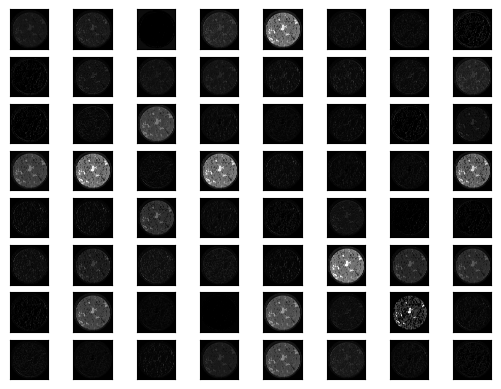

In [43]:
square = 8
ix=1

for _ in range(square):
  for _ in range(square):
    ax = plt.subplot(square, square, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(features[0,:,:,ix-1], cmap='gray')
    ix += 1
plt.show()



Random forest part 

In [46]:
X = features
X = X.reshape(-1, X.shape[3])
Y = Y_train.reshape(-1)

dataset = pd.DataFrame(X)
dataset['Label'] = Y

print(dataset['Label'].unique())
print(dataset['Label'].value_counts())

# Drop all the values to zero as the pixel values are zero for the background
dataset = dataset[dataset['Label'] != 0]

X = dataset.drop(labels = ['Label'], axis=1)
Y = dataset['Label']

[0 2 3 1 4]
0    8854177
3     137953
1      94327
2      65182
4      27497
Name: Label, dtype: int64


Build and fit the random forest model

In [47]:
model = RandomForestClassifier(n_estimators=50, random_state=42)
model.fit(X, Y)

RandomForestClassifier(n_estimators=50, random_state=42)

Save the model

In [49]:
filename = "VGGfeatureextractor_and_rf_classifier.sav"
pickle.dump(model, open(filename, 'wb'))

Let's load and see what happens

In [50]:
model = pickle.load(open(filename, 'rb'))

Test the model

1/1 [==============================] - 3s 3s/step


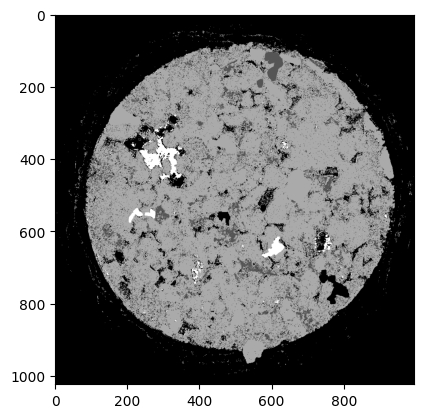

In [52]:
test_image = cv2.imread('/content/data/train_images/image_1.png', cv2.IMREAD_COLOR)
test_image = cv2.resize(test_image, (Size_Y, Size_X))
test_image = cv2. cvtColor(test_image, cv2.COLOR_RGB2BGR)
test_image = np.expand_dims(test_image, axis=0)

X_test_feature = new_model.predict(test_image)
X_test_feature = X_test_feature.reshape(-1, X_test_feature.shape[3])

prediction = model.predict(X_test_feature)

prediction = prediction.reshape(mask.shape)
plt.imshow(prediction, cmap='gray')
plt.imsave('segmented_image.jpg', prediction, cmap='gray')


Reference: @author: Sreenivas Bhattiprolu
https://github.com/bnsreenu